In [3]:
pip install mlflow scikit-learn pandas numpy

  Using cached mlflow-2.22.0-py3-none-any.whl.metadata (30 kB)
Using cached mlflow-2.22.0-py3-none-any.whl (29.0 MB)


In [16]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
import mlflow
import mlflow.sklearn
import pickle
import time
import matplotlib.pyplot as plt


In [6]:
# Cell 2: Load the data
# Replace 'customer_data.csv' with your actual file path
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/marketing_campaign.csv')
data.head()  # Display first few rows to verify loading

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [18]:
# Data preprocessing - Handle missing values
print("Missing values before handling:")
print(data.isnull().sum())



Missing values before handling:
ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
Age                    0
Total_Spending         0
Total_Children         0
Total_Purchases        0
dtype: int64


In [19]:
# Fill missing income values with median
data['Income'] = data['Income'].fillna(data['Income'].median())

print("\nMissing values after handling:")
print(data.isnull().sum())



Missing values after handling:
ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
Age                    0
Total_Spending         0
Total_Children         0
Total_Purchases        0
dtype: int64


In [20]:
# Feature engineering
# Convert birth year to age (assuming current year is 2023)
data['Age'] = 2023 - data['Year_Birth']

# Calculate total spending across all categories
data['Total_Spending'] = data[['MntWines', 'MntFruits', 'MntMeatProducts',
                              'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)

# Calculate total children at home
data['Total_Children'] = data['Kidhome'] + data['Teenhome']

# Calculate total purchases across all channels
data['Total_Purchases'] = data[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

# Display the new features
data[['Age', 'Total_Spending', 'Total_Children', 'Total_Purchases']].head()

,Age,Total_Spending,Total_Children,Total_Purchases
0,66,1617,0,22
1,69,27,2,4
2,58,776,0,20
3,39,53,1,6
4,42,422,1,14


In [21]:
# Encode categorical variables
label_encoders = {}
categorical_cols = ['Education', 'Marital_Status']

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
    print(f"{col} classes:", le.classes_)
    print(f"{col} encoded values:", le.transform(le.classes_))

Education classes: [0 1 2 3 4]
Education encoded values: [0 1 2 3 4]
Marital_Status classes: [0 1 2 3 4 5 6 7]
Marital_Status encoded values: [0 1 2 3 4 5 6 7]


In [22]:
# Select features and target
features = ['Age', 'Education', 'Marital_Status', 'Income', 'Total_Children',
            'Recency', 'Total_Spending', 'Total_Purchases', 'NumWebVisitsMonth']
X = data[features]
y = data['Response']

print("Feature shapes:", X.shape, y.shape)

Feature shapes: (2240, 9) (2240,)


In [23]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])

Training set size: 1792
Test set size: 448


In [27]:
# Cell 8: Set up MLflow experiment
mlflow.set_experiment("Customer_Response_Prediction")

# Start MLflow run
with mlflow.start_run():
    # Cell 9: Train Random Forest model
    model = RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        random_state=42
    )
    start_time = time.time()  # Start timing
    model.fit(X_train, y_train)
    training_time = time.time() - start_time  # Calculate duration
     # Cell 10: Make predictions
    y_pred = model.predict(X_test)

    # Cell 11: Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Training Time: {training_time:.2f} seconds")

    # Cell 12: Log parameters and metrics to MLflow
    mlflow.log_param("n_estimators", 100)
    mlflow.log_param("max_depth", 5)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision", precision)
    mlflow.log_metric("recall", recall)
    mlflow.log_metric("f1_score", f1)
    mlflow.log_metric("training_time", training_time)  # Log training time

    # Cell 13: Log model
    mlflow.sklearn.log_model(model, "random_forest_model")


Accuracy: 0.85
Precision: 0.67
Recall: 0.09
F1 Score: 0.15
Training Time: 0.74 seconds


2025/06/01 20:50:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [30]:
# Cell 14: Save model and label encoders locally
with open('Model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('Label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

print("Model and label encoders saved successfully")

Model and label encoders saved successfully


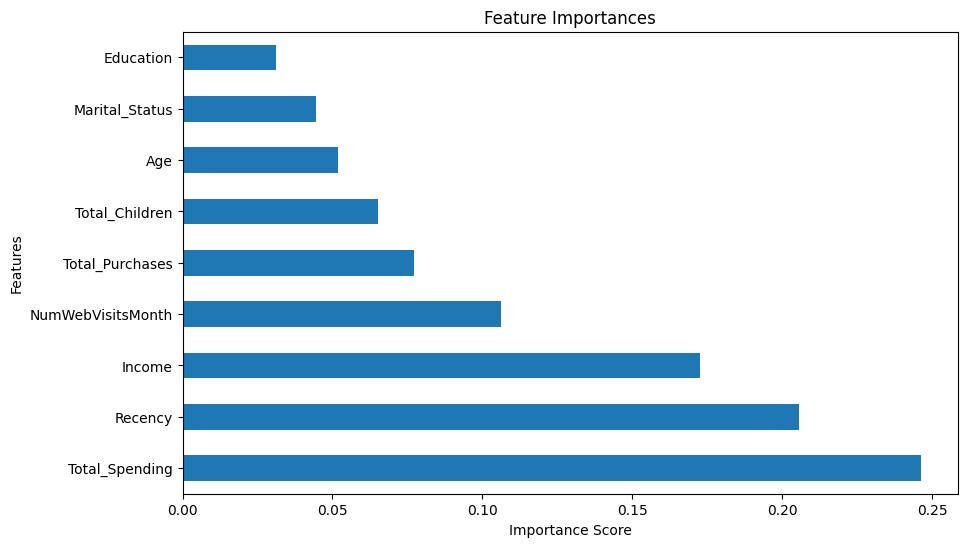

In [29]:
# Cell 15: Feature importance analysis (optional)
feature_importances = pd.Series(model.feature_importances_, index=features)
feature_importances.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh')
plt.title("Feature Importances")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()